In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Reading the output of the autoML algorithm searching for best models for biscuits
df=pd.read_csv('custardModels28_11_2022.csv',index_col='Unnamed: 0')
#shuffle splits of 10, 2 thirds splits
# 3.9.13 python,  matplotlib==3.5.1
df.columns

Index(['feature_preprocessor_type', 'feature_preprocessor_hyperparams',
       'regressor', 'regressor_hyperparams', 'data_preprocessor_type',
       'data_preprocessor_hyperparams', 'R2', 'R2normalized',
       'ENSEMBLE WEIGHT', 'ENSEMBLE WEIGHT normalized', 'MEAN FIT TIME',
       'MEAN FIT TIME normalized'],
      dtype='object')

In [2]:
#Reformatting models dataframe
df.replace(np.nan,{},regex=True)
regressor_hyperparams=df['regressor_hyperparams'].map(eval,na_action='ignore').apply(pd.Series)
df=df.drop('regressor_hyperparams',axis=1)
data_hyperparams=df['data_preprocessor_hyperparams'].map(eval,na_action='ignore').apply(pd.Series)
df=df.drop('data_preprocessor_hyperparams',axis=1)
feature_hyperparams=df['feature_preprocessor_hyperparams'].map(eval,na_action='ignore').apply(pd.Series)
df=df.drop('feature_preprocessor_hyperparams',axis=1)
df.sort_values(by=['R2'],inplace = True,ascending=False)
for column in regressor_hyperparams:
    regressor_hyperparams.loc[regressor_hyperparams[column].notnull(), column]=regressor_hyperparams.loc[regressor_hyperparams[column].notnull(),column].apply(lambda x: x['data'] )
for column in data_hyperparams:
    data_hyperparams.loc[data_hyperparams[column].notnull(), column]=data_hyperparams.loc[data_hyperparams[column].notnull(),column].apply(lambda x: x['data'] )
for column in feature_hyperparams:
    feature_hyperparams.loc[feature_hyperparams[column].notnull(), column]=feature_hyperparams.loc[feature_hyperparams[column].notnull(),column].apply(lambda x: x['data'] )
    

<AxesSubplot:xlabel='regressor'>

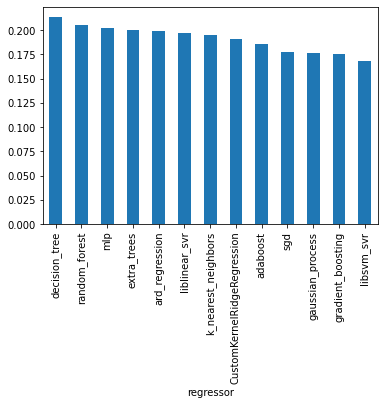

In [3]:
#models over r2 threshold
threshold=0.15
overdf = df.drop(df[df['R2']<threshold].index)
r2ByModel=overdf.groupby(['regressor'])['R2'].mean()
r2ByModel.sort_values(inplace = True,ascending=False)
r2ByModel.plot.bar()

<AxesSubplot:title={'center':'Regressor type counts of the best 845 models (by R2)'}, xlabel='regressor'>

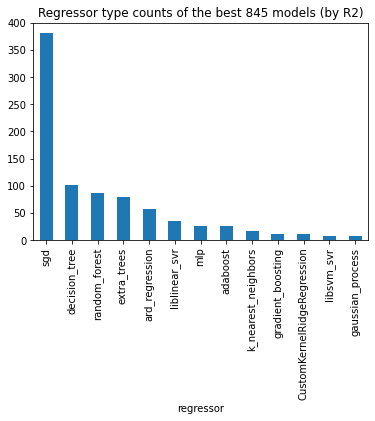

In [4]:
#another view of best models
r2ByModel=overdf.groupby(['regressor'])['R2'].mean()
r2ByModel.sort_values(inplace = True,ascending=False)
r2ByModel.plot.bar()

r2ByModel=overdf.groupby(['regressor'])['R2'].count()
r2ByModel.sort_values(inplace = True,ascending=False)
r2ByModel.plot.bar(title='Regressor type counts of the best '+str(len(overdf))+' models (by R2)')

In [5]:
#joining model dataframes
regressor_hyperparams = regressor_hyperparams.add_suffix('_regressor_hyperparams')
feature_hyperparams = feature_hyperparams.add_suffix('_feature_hyperparams')
data_hyperparams = data_hyperparams.add_suffix('_data_hyperparams')

df=df.join(regressor_hyperparams)
df=df.join(feature_hyperparams)
df=df.join(data_hyperparams)
df.to_csv('parsedModels.csv')

In [6]:
#df2 will only contain models used in best ensemble, and those will be the only ones tested next
df2=df[df['ENSEMBLE WEIGHT'] > 0].dropna(how='all',axis=1)

In [7]:
# Mutual Information and Pearson correlations of the predictors to target variable bioaccessibility
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

dfData=pd.read_csv('forAutoML.csv',index_col='Unnamed: 0')
dfData = dfData.drop(dfData[dfData.Water < 500].index)
X=dfData.copy()
y=dfData.pop('bioaccessibility')
corrs=X.corr()
X.pop('bioaccessibility')
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
print('mi_scores')
print(mi_scores)
corrs=corrs.reindex(corrs.bioaccessibility.abs().sort_values(ascending=False).index)
print('pearson coefficients')
print(corrs['bioaccessibility'])

mi_scores
Cellulose                                       0.264297
Biscuit breaking point                          0.243746
Crème viscosity                                 0.221575
Binding capacity (micromolar)                   0.220509
D 4 3 - Volume weighted mean (particle size)    0.215075
b                                               0.195009
Exp. oil retention                              0.191892
Crème min texture                               0.187990
C                                               0.186627
Crème max texture                               0.184946
Specific surface area                           0.179742
Insoluble fiber                                 0.151493
Bulk density                                    0.150069
L                                               0.145770
Exp. Water retention final                      0.134334
Soluble fiber                                   0.132790
Fat                                             0.127251
Carbs                

In [8]:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor,RandomTreesEmbedding
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import sklearn.feature_selection
import math 

#big loop to rebuild the ensemble with best model algorithms using their final configurations by reading df2 (models of the final ensemble)
models=[]
ensemble_weights=[]
count=0


count=1
for index, row in df2.iterrows():
    pipeline=[]
    if row['numerical_transformer_imputation_strategy_data_hyperparams']!=np.nan:
        pipeline.append(('sklearn.impute.SimpleImputer',SimpleImputer(strategy=row['numerical_transformer_imputation_strategy_data_hyperparams'])))
    
    if row['numerical_transformer_rescaling_data_hyperparams']=='minmax':
        pipeline.append(('sklearn.preprocessing.MinMaxScaler',MinMaxScaler()))
    if row['numerical_transformer_rescaling_data_hyperparams']=='quantile_transformer':
        pipeline.append(('sklearn.preprocessing.QuantileTransformer',QuantileTransformer(n_quantiles=row['numerical_transformer_rescaling_quantile_transformer_n_quantiles_data_hyperparams'],output_distribution=row['numerical_transformer_rescaling_quantile_transformer_output_distribution_data_hyperparams'])))
    
    if row['numerical_transformer_rescaling_data_hyperparams']=='robust_scaler':
        from scipy import sparse
        X_train, X_valid, y_train, y_valid=train_test_split(dfData, y,train_size=0.666, test_size=0.333,random_state=2)
        rs = ShuffleSplit(n_splits=1, test_size=.33, random_state=0)
        rs.get_n_splits(X_train)
        for train_index, test_index in rs.split(X_train):
            X_train2=X_train.iloc[train_index,:]
        if sparse.isspmatrix(X_train2):
            pipeline.append(('sklearn.preprocessing.RobustScaler',RobustScaler(with_centering=False,copy=False,quantile_range=(row['numerical_transformer_rescaling_robust_scaler_q_min_data_hyperparams'],row['numerical_transformer_rescaling_robust_scaler_q_max_data_hyperparams']))))
        else:
            pipeline.append(('sklearn.preprocessing.RobustScaler',RobustScaler(copy=False,quantile_range=(row['numerical_transformer_rescaling_robust_scaler_q_min_data_hyperparams'],row['numerical_transformer_rescaling_robust_scaler_q_max_data_hyperparams']))))
        
    if row['numerical_transformer_rescaling_data_hyperparams']=='power_transformer':
        pipeline.append(('sklearn.preprocessing.PowerTransformer',PowerTransformer()))
    
    if row['feature_preprocessor_type']=='polynomial':
        pipeline.append(('sklearn.preprocessing.PolynomialFeatures',sklearn.preprocessing.PolynomialFeatures(degree=row['degree_feature_hyperparams'],include_bias=row['include_bias_feature_hyperparams'],interaction_only=row['interaction_only_feature_hyperparams'])))
    elif row['feature_preprocessor_type']=='feature_agglomeration':
        n_clusters=29 if row['n_clusters_feature_hyperparams']>29 else  row['n_clusters_feature_hyperparams']
        pooling_func_dict=dict(mean=np.mean, median=np.median, max=np.max)
        pipeline.append(('sklearn.cluster.FeatureAgglomeration',FeatureAgglomeration(affinity=row['affinity_feature_hyperparams'],linkage=row['linkage_feature_hyperparams'],n_clusters=n_clusters,pooling_func=pooling_func_dict[row['pooling_func_feature_hyperparams']])))
    elif row['feature_preprocessor_type']=='select_rates_regression':
        if row['score_func_feature_hyperparams'] == "f_regression":
            score_func = sklearn.feature_selection.f_regression
            mode=row['mode_feature_hyperparams']
        elif score_func == "mutual_info_regression":
            from functools import partial
            score_func = partial(
                sklearn.feature_selection.mutual_info_regression,
                random_state=None
            )
            # Mutual info consistently crashes if percentile is not the mode
            mode = "percentile"
            #for a particular case of 0.1 alpha , there is a split in which alpha is too large when splitting internally again, so change random_state of split sometimes
        pipeline.append(('sklearn.feature_selection.GenericUnivariateSelect',sklearn.feature_selection.GenericUnivariateSelect(mode=mode,score_func=score_func,param=row['alpha_feature_hyperparams'])))
        
    elif row['feature_preprocessor_type']=='select_percentile_regression':
        if row['score_func_feature_hyperparams'] == "f_regression":
            score_func = sklearn.feature_selection.f_regression
            mode=row['mode_feature_hyperparams']
        elif score_func == "mutual_info_regression":
            from functools import partial
            score_func = partial(
                sklearn.feature_selection.mutual_info_regression,
                random_state=None
            )
        pipeline.append(('sklearn.feature_selection.SelectPercentile',sklearn.feature_selection.SelectPercentile(score_func=score_func,percentile=row['percentile_feature_hyperparams'])))
    elif row['feature_preprocessor_type']=='random_trees_embedding':
        max_depth=None if math.isnan(row['max_depth_feature_hyperparams']) else int(row['max_depth_feature_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_feature_hyperparams']=='None' else int(row['max_leaf_nodes_feature_hyperparams']) 
        min_samples_leaf=None if math.isnan(row['min_samples_leaf_feature_hyperparams']) else int(row['min_samples_leaf_feature_hyperparams'])
        min_samples_split=None if math.isnan(row['min_samples_split_feature_hyperparams']) else int(row['min_samples_split_feature_hyperparams'])
       
        pipeline.append(('sklearn.ensemble.RandomTreesEmbedding',RandomTreesEmbedding(max_depth=max_depth,max_leaf_nodes=max_leaf_nodes,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'],n_estimators=row['n_estimators_feature_hyperparams'])))
    elif row['feature_preprocessor_type']=='pca':
        pipeline.append(('sklearn.decomposition.PCA',sklearn.decomposition.PCA(n_components=row['keep_variance_feature_hyperparams'],whiten=row['whiten_feature_hyperparams'],copy=True)))
    




    if row['regressor']=='extra_trees':
        max_depth=None if row['max_depth_regressor_hyperparams']=='None' else int(row['max_depth_regressor_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams']) 
        pipeline.append(('sklearn.ensemble.ExtraTreesRegressor',ExtraTreesRegressor(bootstrap=row['bootstrap_regressor_hyperparams'],criterion=row['criterion_regressor_hyperparams'],max_depth=max_depth,max_features=row['max_features_regressor_hyperparams'],max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=row['min_impurity_decrease_regressor_hyperparams'],min_samples_leaf=row['min_samples_leaf_regressor_hyperparams'],min_samples_split=row['min_samples_split_regressor_hyperparams'],min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'])))
        
    elif row['regressor']=='random_forest':
        max_depth=None if row['max_depth_regressor_hyperparams']=='None' else int(row['max_depth_regressor_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams']) 
        pipeline.append(('sklearn.ensemble.RandomForestRegressor',RandomForestRegressor(bootstrap=row['bootstrap_regressor_hyperparams'],criterion=row['criterion_regressor_hyperparams'],max_depth=max_depth,max_features=row['max_features_regressor_hyperparams'],max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=row['min_impurity_decrease_regressor_hyperparams'],min_samples_leaf=row['min_samples_leaf_regressor_hyperparams'],min_samples_split=row['min_samples_split_regressor_hyperparams'],min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'])))
    
    elif row['regressor']=='mlp':
        if row['early_stopping_regressor_hyperparams'] == "train":
            #n_iter_no_change = int(n_iter_no_change)
            validation_fraction_ = row['validation_fraction_regressor_hyperparams']
            tol=row['tol_regressor_hyperparams']
            iter_no_change=row['n_iter_no_change_regressor_hyperparams']
            early_stopping=False
        elif row['early_stopping_regressor_hyperparams'] == "valid":
            #n_iter_no_change = int(n_iter_no_change)
            #validation_fraction_ = float(validation_fraction_)
            iter_no_change=row['n_iter_no_change_regressor_hyperparams']
            validation_fraction_ = row['validation_fraction_regressor_hyperparams']
            early_stopping=True
            tol=row['tol_regressor_hyperparams']
        hidden_layer_sizes = tuple(
                row['num_nodes_per_layer_regressor_hyperparams'] for i in range(row['hidden_layer_depth_regressor_hyperparams'])
            )
        pipeline.append(('sklearn.neural_network.MLPRegressor',MLPRegressor(max_iter=5000,activation=row['activation_regressor_hyperparams'],tol=tol,n_iter_no_change=iter_no_change,validation_fraction=validation_fraction_,early_stopping=early_stopping,alpha=row['alpha_regressor_hyperparams'],batch_size=row['batch_size_regressor_hyperparams'],beta_1=row['beta_1_regressor_hyperparams'],beta_2=row['beta_2_regressor_hyperparams'],epsilon=row['epsilon_regressor_hyperparams'],hidden_layer_sizes=hidden_layer_sizes,learning_rate_init=row['learning_rate_init_regressor_hyperparams'],shuffle=bool(row['shuffle_regressor_hyperparams']),solver=row['solver_regressor_hyperparams'])))
    #max_iter=100000,
    
    elif row['regressor']=='decision_tree':
        max_depth=None if math.isnan(row['max_depth_regressor_hyperparams']) else int(row['max_depth_regressor_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams']) 
        min_samples_leaf=None if math.isnan(row['min_samples_leaf_regressor_hyperparams']) else int(row['min_samples_leaf_regressor_hyperparams'])
        min_samples_split=None if math.isnan(row['min_samples_split_regressor_hyperparams']) else int(row['min_samples_split_regressor_hyperparams'])
       
        pipeline.append(('sklearn.tree.DecisionTreeRegressor',DecisionTreeRegressor(criterion=row['criterion_regressor_hyperparams'],max_depth=max_depth,max_features=row['max_features_regressor_hyperparams'],max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=row['min_impurity_decrease_regressor_hyperparams'],min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_leaf,min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'])))
    
    elif row['regressor']=='gradient_boosting':
        max_depth=None if row['max_depth_regressor_hyperparams']=='None' else int(row['max_depth_regressor_hyperparams'])
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams'])
        if row['early_stop_regressor_hyperparams'] == "off":
            n_iter_no_change = 0
            validation_fraction_ = None
        elif row['early_stop_regressor_hyperparams'] == "train":
            #n_iter_no_change = int(n_iter_no_change)
            n_iter_no_change = 10
            validation_fraction_ = None
        elif row['early_stop_regressor_hyperparams'] == "valid":
            #n_iter_no_change = int(n_iter_no_change)
            #validation_fraction_ = float(validation_fraction_)
            n_iter_no_change = 10
            validation_fraction_ = 0.1
        min_samples_leaf=None if math.isnan(row['min_samples_leaf_regressor_hyperparams']) else int(row['min_samples_leaf_regressor_hyperparams'])
        
        pipeline.append(('sklearn.ensemble.HistGradientBoostingRegressor',HistGradientBoostingRegressor(n_iter_no_change=n_iter_no_change,validation_fraction=validation_fraction_,l2_regularization=row['l2_regularization_regressor_hyperparams'],learning_rate=row['learning_rate_regressor_hyperparams'],loss=row['loss_regressor_hyperparams'],max_bins=row['max_bins_regressor_hyperparams'],max_depth=max_depth,max_leaf_nodes=max_leaf_nodes,min_samples_leaf=min_samples_leaf,tol=row['tol_regressor_hyperparams'])))

    elif row['regressor']=='ard_regression':
        pipeline.append(('sklearn.linear_model.ARDRegression',ARDRegression(alpha_1=row['alpha_1_regressor_hyperparams'],alpha_2=row['alpha_2_regressor_hyperparams'],lambda_1=row['lambda_1_regressor_hyperparams'],lambda_2=row['lambda_2_regressor_hyperparams'],n_iter=row['n_iter_regressor_hyperparams'],threshold_lambda=row['threshold_lambda_regressor_hyperparams'],tol=row['tol_regressor_hyperparams'])))
    
    
    elif row['regressor']=='liblinear_svr':
        continue#cant make it work
        dual=bool(row['dual_regressor_hyperparams'])
        loss=row['loss_regressor_hyperparams']
        #if row['dual_regressor_hyperparams']=='False' and row['loss_regressor_hyperparams']=='squared_epsilon_insensitive':
        #    loss='epsilon_insensitive'
        #had to increase max_iter (so there is convergence) as I cannot figure out why I cannot reproduce model.max_iter=1000,
        pipeline.append(('sklearn.svm.LinearSVR',sklearn.svm.LinearSVR(epsilon=row['epsilon_regressor_hyperparams'],loss=loss,dual=dual,tol=row['tol_regressor_hyperparams'],C=row['C_regressor_hyperparams'],fit_intercept=row['fit_intercept_regressor_hyperparams'],intercept_scaling=row['intercept_scaling_regressor_hyperparams'])))
    
    elif row['regressor']=='gaussian_process':
        n_features=29######################
        kernel = sklearn.gaussian_process.kernels.RBF(
            length_scale=[1.0] * n_features,
            length_scale_bounds=[(row['thetaL_regressor_hyperparams'], row['thetaU_regressor_hyperparams'])] * n_features,
        )
        pipeline.append(('sklearn.gaussian_process.GaussianProcessRegressor',GaussianProcessRegressor(kernel=kernel,alpha=row['alpha_regressor_hyperparams'])))

    
    models.append((str(count)+'_'+row['regressor']+'_'+str(row['R2']),Pipeline(pipeline)))
    ensemble_weights.append(row['ENSEMBLE WEIGHT'])
    count=count+1

print(models)
for i in models:
    print(type(i))

[('1_random_forest_0.2887661443545942', Pipeline(steps=[('sklearn.impute.SimpleImputer',
                 SimpleImputer(strategy='most_frequent')),
                ('sklearn.feature_selection.SelectPercentile',
                 SelectPercentile(percentile=18.630339040767723,
                                  score_func=<function f_regression at 0x0000019D25C883A0>)),
                ('sklearn.ensemble.RandomForestRegressor',
                 RandomForestRegressor(bootstrap='False',
                                       criterion='friedman_mse',
                                       max_features=0.49024184071789956,
                                       min_samples_leaf=7,
                                       min_samples_split=18))])), ('2_mlp_0.2791343027257889', Pipeline(steps=[('sklearn.impute.SimpleImputer',
                 SimpleImputer(strategy='median')),
                ('sklearn.neural_network.MLPRegressor',
                 MLPRegressor(alpha=1.8717856827681902e-05,
    

C:\Users\acast\AppData\Local\Temp/ipykernel_19284/1009490125.py:1: DeprecationWarning: The symbol module is deprecated and will be removed in future versions of Python
  from symbol import eval_input
C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1387) is greater than the total number of samples (48). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1387) is greater than the total number of samples (48). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n

3.358761804319207
0.25379848685728784


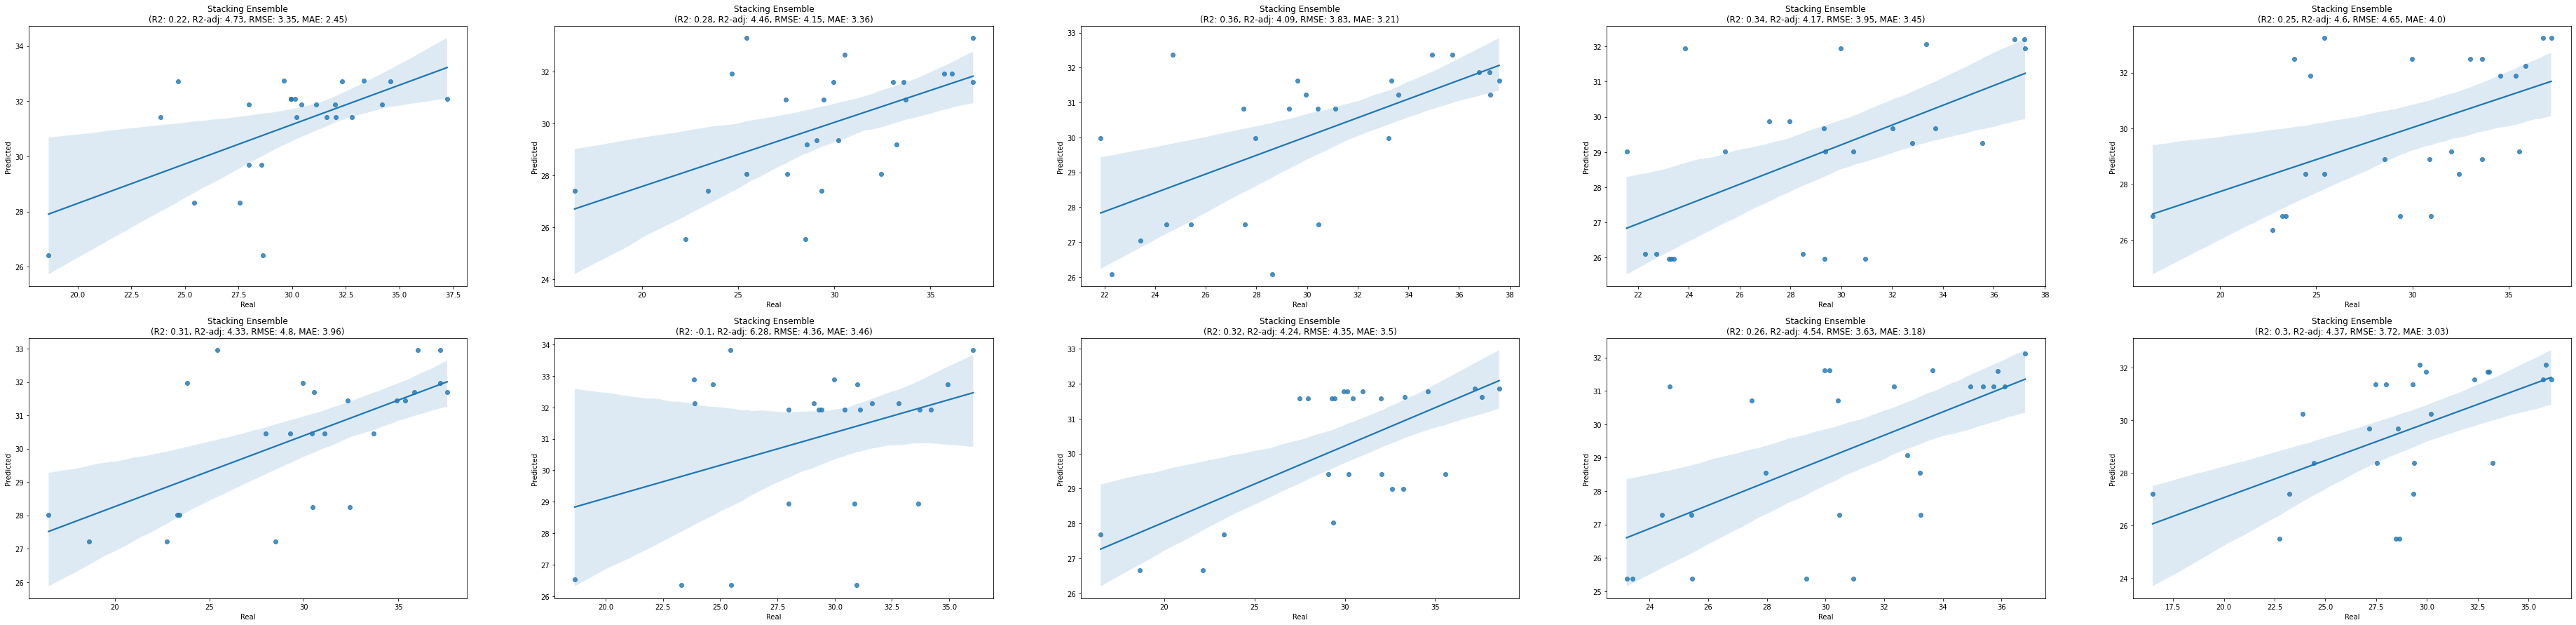

In [9]:
from symbol import eval_input
from sklearn.svm import LinearSVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# evaluate the ensemble across several splits visually
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		mae = mean_absolute_error(y_val, yhat)
		# store the performance
		scores.append(-mae)
		# report model performance
	return scores


X_train, X_valid, y_train, y_valid=train_test_split(dfData, y,train_size=0.666, test_size=0.333,random_state=None)
#holdout for testing the valid

# fit and evaluate each model with 10 shuffle splits (same as when they were optimised)
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=10, test_size=.33, random_state=2)
rs.get_n_splits(X_train)
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(65, 15)
row=0
column=0
mean_errors=[]
r2_scores=[]
for train_index, test_index in rs.split(X_train):
    X_train2=X_train.iloc[train_index,:]
    y_train2=y_train.iloc[train_index]
    X_valid2=X_train.iloc[test_index,:]
    y_valid2=y_train.iloc[test_index]

    # create the ensemble
    ensemble = VotingRegressor(estimators=models, weights=ensemble_weights)

    ensemble.fit(X_train2,y_train2)
    predictions = ensemble.predict(X_valid2)

    
    sns.regplot(ax=axes[column,row],x=y_valid2,y=predictions)
    axes[column,row].set_title("Stacking Ensemble\n(R2: "+str(round(r2_score(y_valid2,predictions),2))+", R2-adj: "+str(round(1-(1-r2_score(y_valid2, predictions))*((len(y_valid2)-1)/(len(y_valid2)-len(X_valid2.columns)-1)),2))+", RMSE: "+str(round(np.sqrt(mean_squared_error(y_valid2,predictions)),2))+", MAE: "+str(round(mean_absolute_error(y_valid2,predictions),2))+")",fontsize=12)
    axes[column,row].set_xlabel('Real')
    axes[column,row].set_ylabel('Predicted')
    row=row+1
    if row==5:
        row=0
        column=1
    mean_errors.append(mean_absolute_error(y_valid2,predictions))
    r2_scores.append(r2_score(y_valid2,predictions))

print(np.mean(mean_errors))
print(np.mean(r2_scores))

C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1387) is greater than the total number of samples (48). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1387) is greater than the total number of samples (48). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1387) is greater than the total number of samples (48). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\acast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kf

[3.2956776955984437, 3.412210837575226, 3.3894157910354825, 3.143771647800578, 3.531068815894494, 3.3452563371056634, 2.8904504240089195, 3.5952625736557295, 3.4257828479216004, 3.145914531486641, 4.060179757894761, 3.397441300450422, 3.642560929841902, 3.171530098551054, 3.2313678915100086, 3.694614606861744, 3.0001922008444804, 3.941325823075282, 3.539424063605495, 3.6203446285901815, 3.671874754897952, 3.5194755779202263, 3.8062976870284446, 3.21675755782134, 3.8279826059414086, 3.657540949176383, 3.168520436071485, 3.1462747991084683, 4.074497642287064, 3.0180677684552846, 3.059553150471163, 3.1240197056498062, 3.26584427490734, 2.6053611891210084, 3.2266439562509404, 3.454964685037689, 5.24724916692989, 4.10334088896459, 3.3717565418152127, 3.518442667501793, 3.2345768010764595, 3.8761575753249815, 3.4448124414480854, 3.15265084376579, 4.175731809656232, 3.5559975666117394, 4.073160172057837, 3.8447528422920563, 3.1414562106580615, 3.4418833710936383, 3.227348853680331, 3.22545695

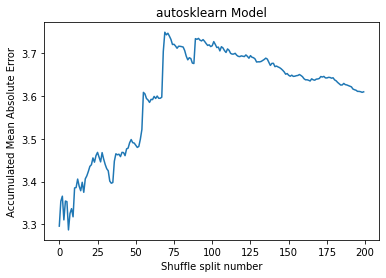

[0.31674103757435323, 0.217322067909279, 0.3434854218078529, 0.3432244446280772, 0.3276993639305462, 0.23391145493598886, 0.3434431913226409, 0.06620527344478866, 0.03337189389788786, 0.2881330398938904, 0.07668057882510437, 0.2756664964088418, 0.33448293021755715, -0.08705280018159955, 0.2678666994219694, 0.17864851418237082, 0.2515069014018093, 0.27922042467594965, 0.18784595411299954, 0.1613075981375418, 0.04413362195902637, 0.07016724103591188, 0.1336535047192221, 0.18184259389430124, 0.299140205725005, 0.12092718122273738, 0.3951778487355827, 0.20214135829642343, 0.27615518256545013, 0.3209332134630467, 0.20740975800190786, 0.2780958221232116, 0.22891405723956038, 0.2928989004462117, 0.29245864597629767, 0.13347905929071258, -1.03522224358352, 0.24371843975208918, 0.32417311027673335, 0.2516930608034713, 0.16586179258683365, 0.24004116019872357, 0.3357600662138831, 0.336550855915843, 0.2778936597099846, -0.0763219211062236, 0.17209097578646582, 0.01813249929325944, 0.0709021148461

Text(0, 0.5, 'Accumulated R2')

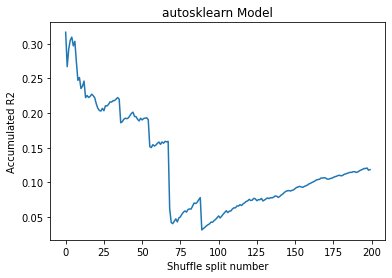

In [10]:
#even more splits to test the stability with accumulated averages
rs = ShuffleSplit(n_splits=200, test_size=.33, random_state=0)
rs.get_n_splits(X_train)
mean_errors=[]
r2_scores=[]
for train_index, test_index in rs.split(X_train):
    X_train2=X_train.iloc[train_index,:]
    y_train2=y_train.iloc[train_index]
    X_valid2=X_train.iloc[test_index,:]
    y_valid2=y_train.iloc[test_index]
    # create the ensemble
    ensemble = VotingRegressor(estimators=models, weights=ensemble_weights)
    ensemble.fit(X_train2,y_train2)
    predictions = ensemble.predict(X_valid2)
    mean_errors.append(mean_absolute_error(y_valid2,predictions))
    r2_scores.append(r2_score(y_valid2,predictions))

accumulated_averages=[]
for i in range(len(mean_errors)):
    level=[mean_errors[z] for z in range(0,i+1)]
    accumulated_averages.append(np.mean(level))
print(mean_errors)
print(accumulated_averages)
plt.plot(accumulated_averages)

plt.title('autosklearn Model')
plt.xlabel('Shuffle split number')
plt.ylabel('Accumulated Mean Absolute Error')
plt.show()

accumulated_r2=[]
for i in range(len(r2_scores)):
    level=[r2_scores[z] for z in range(0,i+1)]
    accumulated_r2.append(np.mean(level))
print(r2_scores)
print(accumulated_r2)
plt.plot(accumulated_r2)

plt.title('autosklearn Model')
plt.xlabel('Shuffle split number')
plt.ylabel('Accumulated R2')

n_quantiles (1387) is greater than the total number of samples (73). n_quantiles is set to n_samples.
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleI

  0%|          | 0/37 [00:00<?, ?it/s]

X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted

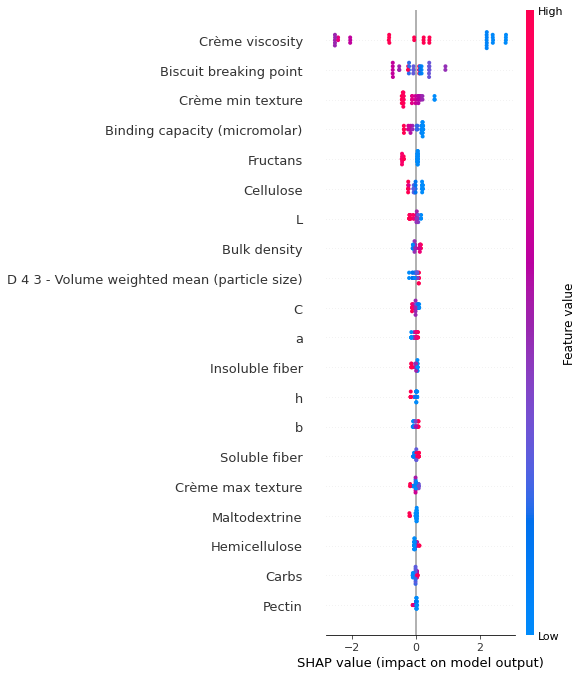

In [11]:
import shap
#Lovely shap summary plots

# Create object that can calculate shap values
# calculate shap values. This is what we will plot.Calculate shap_values for all of val_X rather than a single row, to have more data for plot.

ensemble.fit(X_train,y_train)
explainer = shap.KernelExplainer(ensemble.predict, X_train)
shap_values = explainer.shap_values(X_valid)

# Make plot
shap.summary_plot(shap_values, X_valid)

In [12]:
# Permutation importance
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(ensemble, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.5415 ± 0.3286,Crème viscosity
0.0456 ± 0.2265,Biscuit breaking point
0.0371 ± 0.0179,Fructans
0.0368 ± 0.0314,Crème min texture
0.0221 ± 0.0270,L
0.0089 ± 0.0130,h
0.0087 ± 0.0070,a
0.0070 ± 0.0108,b
0.0041 ± 0.0168,D 4 3 - Volume weighted mean (particle size)
0.0036 ± 0.0072,Hemicellulose
